In [622]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots
using ProgressMeter

import Base: show
import PDMats: PDMat

In [781]:
function hgf(n, iters, data)
    model = Model(DefaultMessageGate())
    
    xt_min = add!(model, datavar(:xt_min, NormalMeanVariance{Float64}))
    xt     = add!(model, simplerandomvar(:xt))
    
    zvar   = add!(model, constvar(:zvar, 0.05))
    zt_min = add!(model, datavar(:zt_min, NormalMeanVariance{Float64}))
    zt     = add!(model, simplerandomvar(:zt))
    
    gaussian = GaussianMeanVarianceNode()
    
    connect!(gaussian, :mean, zt_min, 1)
    connect!(gaussian, :variance, zvar, 1)
    connect!(gaussian, :value, zt, 1)
    
    kt = add!(model, datavar(:kt, NormalMeanVariance{Float64}))
    ωt = add!(model, datavar(:wt, NormalMeanVariance{Float64}))
    
    gcv = add!(model, GCVNode())
    
    connect!(gcv, :x, xt_min, 1)
    connect!(gcv, :y, xt, 1)
    connect!(gcv, :z, zt, 2)
    connect!(gcv, :κ, kt, 1)
    connect!(gcv, :ω, ωt, 1)
    
    add_noise = add!(model, AdditionNode())
    noise     = add!(model, constvar(:noise, NormalMeanVariance(0.0, 20.0)))
    
    connect!(add_noise, :in1, xt, 2)
    connect!(add_noise, :in2, noise, 1)
    
    y = add!(model, datavar(:y, Float64))
    
    connect!(add_noise, :out, y, 1)
    
    activate!(model, gaussian)
    activate!(model, gcv)
    activate!(model, add_noise)
    
    # Prior marginals
    setmarginal!(gcv, :xy, MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat([ 5.0 0.0 ; 0.0 5.0 ])))
    setmarginal!(gcv, :z, NormalMeanVariance(0.0, 5.0))
    setmarginal!(gcv, :κ, NormalMeanVariance(0.0, 5.0))
    setmarginal!(gcv, :ω, NormalMeanVariance(0.0, 5.0))
    
    mk = Vector{NormalMeanVariance}()
    mw = Vector{NormalMeanVariance}()
    mz = Vector{NormalMeanVariance}()
    mx = Vector{NormalMeanVariance}()

    s_mk = subscribe!(getmarginal(kt), (t) -> push!(mk, getdata(t)))
    s_mw = subscribe!(getmarginal(ωt), (t) -> push!(mw, getdata(t)))
    s_mz = subscribe!(getmarginal(zt), (t) -> push!(mz, getdata(t)))
    s_mx = subscribe!(getmarginal(xt), (t) -> push!(mx, getdata(t)))
    
    # Initial messages
    current_zt = NormalMeanVariance(0.0, 1.0)
    current_kt = NormalMeanVariance(0.0, 1.0)
    current_ωt = NormalMeanVariance(0.0, 1.0)
    current_xt = NormalMeanVariance(0.0, 1.0)
    
    mk_out = Vector{NormalMeanVariance}(undef, n)
    mw_out = Vector{NormalMeanVariance}(undef, n)
    mz_out = Vector{NormalMeanVariance}(undef, n)
    mx_out = Vector{NormalMeanVariance}(undef, n)
    
    @showprogress for i in 1:n
        for _ in 1:iters
            update!(y, data[i])
            update!(zt_min, current_zt)
            update!(kt, current_kt)
            update!(ωt, current_ωt)
            update!(xt_min, current_xt)
        end
        
        current_zt = mz[end]
        current_kt = mk[end]
        current_ωt = mw[end]
        current_xt = mx[end]
        
        mk_out[i] = current_kt
        mw_out[i] = current_ωt
        mz_out[i] = current_zt
        mx_out[i] = current_xt
    end
    
    unsubscribe!(s_mk)
    unsubscribe!(s_mw)
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    
    return mx_out, mk_out, mw_out, mz_out
end

hgf (generic function with 1 method)

In [782]:
n = 1000
iters = 20

real_k = 1.0
real_w = 0.0

z_prev     = 0.0
z_variance = 0.05

z = Vector{Float64}(undef, n)
for i in 1:n
    z[i] = rand(Normal(z_prev, z_variance))
    z_prev = z[i]
end

v = map(d -> exp(real_k * d + real_w), z)
y = Vector{Float64}(undef, n)

y_prev = 0.0

for i in 1:n
    y[i] = rand(Normal(y_prev, v[i]))
    y_prev = y[i]
end

obs_noise = 20.0

data = map(d -> d + rand(Normal(0, sqrt(obs_noise))), y);

In [783]:
@time mx, mk, mw, mz = hgf(n, iters, data);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  1.748336 seconds (7.92 M allocations: 413.743 MiB, 10.08% gc time)


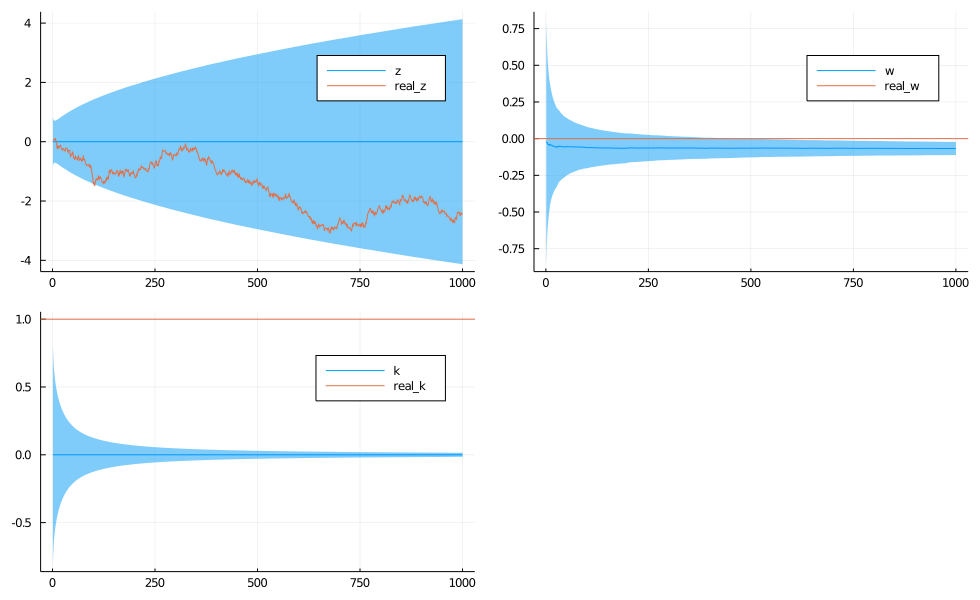

In [784]:
plot(mean.(mz), ribbon = std.(mz), label = :z)
p1 = plot!(z, label = :real_z)

plot(mean.(mw), ribbon = std.(mw), label = :w)
p2 = plot!([ real_w ], seriestype=:hline, label = :real_w)

plot(mean.(mk), ribbon = std.(mk), label = :k)
p3 = plot!([ real_k ], seriestype=:hline, label = :real_k)

plot(p1, p2, p3, size = (980, 600))

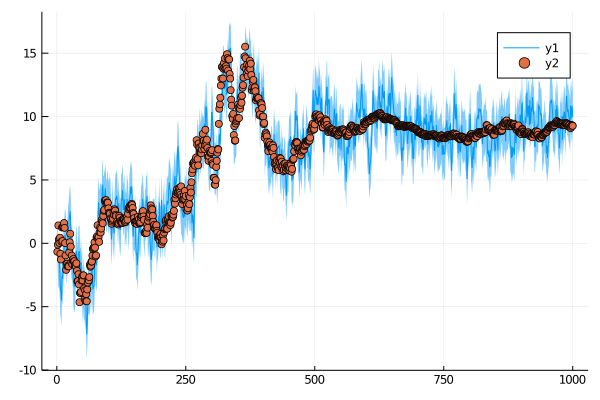

In [785]:
plot(mean.(mx), ribbon = std.(mx))
# scatter!(data)
scatter!(y)